In [1]:
import copy
from pathlib import Path
import warnings

import torch
import numpy as np
import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
data = pd.read_pickle('../M5_Dataset/tft_dataset.pkl')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135870 entries, 0 to 135869
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   store_id      135870 non-null  category      
 1   dept_id       135870 non-null  category      
 2   state_id      135870 non-null  category      
 3   cat_id        135870 non-null  category      
 4   Node          135870 non-null  category      
 5   d             135870 non-null  int16         
 6   sold          135870 non-null  float64       
 7   date          135870 non-null  datetime64[ns]
 8   weekday       135870 non-null  category      
 9   wday          135870 non-null  category      
 10  month         135870 non-null  category      
 11  event_name_1  135870 non-null  category      
 12  event_type_1  135870 non-null  category      
 13  event_name_2  135870 non-null  category      
 14  event_type_2  135870 non-null  category      
 15  snap_CA       135

In [12]:
data["month"] = data["month"].astype(str).astype("category")

In [13]:
max_prediction_length = 28
max_encoder_length = 56
training_cutoff = data["d"].max() - max_prediction_length

In [14]:
special_days = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
snap_days = ['snap_CA', 'snap_TX', 'snap_WI']

In [16]:
data[snap_days] = data[snap_days].astype(str).astype("category")

In [18]:
dataset = TimeSeriesDataSet(
    data[lambda x: x.d <= training_cutoff],
    time_idx="d",
    target="sold",
    group_ids=["Node"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Node", "store_id", "dept_id", "state_id", 'cat_id'],
    time_varying_known_categoricals=["special_days", "month", "snap_days"],
    variable_groups={"special_days": special_days, "snap_days": snap_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["d"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["sold"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

In [19]:
dataset.get_parameters()

{'time_idx': 'd',
 'target': 'sold',
 'group_ids': ['Node'],
 'weight': None,
 'max_encoder_length': 56,
 'min_encoder_length': 28,
 'min_prediction_idx': 1,
 'min_prediction_length': 1,
 'max_prediction_length': 28,
 'static_categoricals': ['Node', 'store_id', 'dept_id', 'state_id', 'cat_id'],
 'static_reals': ['encoder_length', 'sold_center', 'sold_scale'],
 'time_varying_known_categoricals': ['special_days', 'month', 'snap_days'],
 'time_varying_known_reals': ['d', 'relative_time_idx'],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['sold'],
 'variable_groups': {'special_days': ['event_name_1',
   'event_type_1',
   'event_name_2',
   'event_type_2'],
  'snap_days': ['snap_CA', 'snap_TX', 'snap_WI']},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': True,
 'add_target_scales': True,
 'add_encoder_length': True,
 'target_normalizer': EncoderNormalizer(),
 'categorical_encoders': {'__group_id__Node': Na

In [20]:
validation = TimeSeriesDataSet.from_dataset(dataset, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 1
train_dataloader = dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size , num_workers=0)

In [24]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    dataset,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 22.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.7 K 
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 2.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

suggested learning rate: 7.762471166286919e-05


Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 24.28it/s]


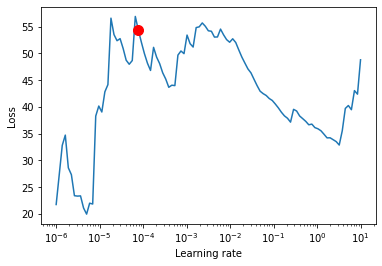

<ipython-input-25-a92b5627800b>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [25]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [27]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    dataset,
    learning_rate=7.762471166286919e-05,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 22.3k


In [28]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.7 K 
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 2.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s]

/opt/anaconda3/envs/pytorch_forecasting/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Global seed set to 42
/opt/anaconda3/envs/pytorch_forecasting/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  31%|███       | 31/100 [00:01<00:04, 15.59it/s, loss=87.8, v_num=2, val_loss=52.10, train_loss_step=7.400]
Validating: 0it [00:00, ?it/s]
Epoch 1:   1%|          | 1/100 [00:00<00:13,  7.57it/s, loss=87.7, v_num=2, val_loss=68.50, train_loss_step=13.70, train_loss_epoch=68.20]  

/opt/anaconda3/envs/pytorch_forecasting/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Epoch 1:  30%|███       | 30/100 [00:01<00:03, 19.71it/s, loss=61, v_num=2, val_loss=68.50, train_loss_step=48.90, train_loss_epoch=68.20]  
Validating: 0it [00:00, ?it/s]
Epoch 2:  30%|███       | 30/100 [00:01<00:03, 19.59it/s, loss=66.8, v_num=2, val_loss=68.00, train_loss_step=147.0, train_loss_epoch=55.40]
Validating: 0it [00:00, ?it/s]
Epoch 3:  30%|███       | 30/100 [00:01<00:03, 20.04it/s, loss=57.3, v_num=2, val_loss=67.40, train_loss_step=13.40, train_loss_epoch=66.70] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  30%|███       | 30/100 [00:01<00:03, 21.02it/s, loss=44.8, v_num=2, val_loss=66.70, train_loss_step=31.60, train_loss_epoch=55.10] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  30%|███       | 30/100 [00:01<00:03, 20.68it/s, loss=42.2, v_num=2, val_loss=65.90, train_loss_step=13.60, train_loss_epoch=50.80] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  30%|███       | 30/100 [00:01<00:03, 20.62it/s, loss=62.2, v_num=2, val_loss=65.00, train_loss_step=6.770, train_loss_epoch=47.

Epoch 8:  30%|███       | 30/100 [00:01<00:03, 20.26it/s, loss=34, v_num=2, val_loss=63.10, train_loss_step=57.40, train_loss_epoch=59.50]   
Validating: 0it [00:00, ?it/s]
Epoch 9:  30%|███       | 30/100 [00:01<00:03, 20.58it/s, loss=65, v_num=2, val_loss=62.10, train_loss_step=27.80, train_loss_epoch=38.80]  
Validating: 0it [00:00, ?it/s]
Epoch 10:  30%|███       | 30/100 [00:01<00:03, 20.37it/s, loss=56.3, v_num=2, val_loss=61.00, train_loss_step=62.60, train_loss_epoch=68.80]
Validating: 0it [00:00, ?it/s]
Epoch 11:  30%|███       | 30/100 [00:01<00:03, 20.76it/s, loss=62.4, v_num=2, val_loss=59.80, train_loss_step=6.310, train_loss_epoch=58.90] 
Validating: 0it [00:00, ?it/s]
Epoch 12:  30%|███       | 30/100 [00:01<00:03, 20.27it/s, loss=53.5, v_num=2, val_loss=58.70, train_loss_step=8.480, train_loss_epoch=51.50] 
Validating: 0it [00:00, ?it/s]
Epoch 13:  30%|███       | 30/100 [00:01<00:03, 20.56it/s, loss=50.9, v_num=2, val_loss=57.50, train_loss_step=23.70, train_loss_epoch

Epoch 15:  30%|███       | 30/100 [00:01<00:03, 21.16it/s, loss=53.7, v_num=2, val_loss=55.20, train_loss_step=4.870, train_loss_epoch=48.00] 
Validating: 0it [00:00, ?it/s]
Epoch 16:  30%|███       | 30/100 [00:01<00:03, 20.77it/s, loss=35.3, v_num=2, val_loss=54.00, train_loss_step=119.0, train_loss_epoch=55.60] 
Validating: 0it [00:00, ?it/s]
Epoch 17:  30%|███       | 30/100 [00:01<00:03, 21.06it/s, loss=56.8, v_num=2, val_loss=52.70, train_loss_step=20.80, train_loss_epoch=58.20] 
Validating: 0it [00:00, ?it/s]
Epoch 18:  30%|███       | 30/100 [00:01<00:03, 20.70it/s, loss=55.2, v_num=2, val_loss=51.50, train_loss_step=3.850, train_loss_epoch=55.60] 
Validating: 0it [00:00, ?it/s]
Epoch 19:  30%|███       | 30/100 [00:01<00:03, 20.78it/s, loss=40.4, v_num=2, val_loss=50.30, train_loss_step=56.20, train_loss_epoch=47.90] 
Validating: 0it [00:00, ?it/s]
Epoch 20:  30%|███       | 30/100 [00:01<00:03, 20.48it/s, loss=46.7, v_num=2, val_loss=49.00, train_loss_step=41.40, train_loss_e

Epoch 21:  30%|███       | 30/100 [00:01<00:03, 21.03it/s, loss=58.5, v_num=2, val_loss=47.80, train_loss_step=24.40, train_loss_epoch=61.50] 
Validating: 0it [00:00, ?it/s]
Epoch 22:  30%|███       | 30/100 [00:01<00:03, 20.76it/s, loss=55.9, v_num=2, val_loss=46.60, train_loss_step=21.50, train_loss_epoch=47.10] 
Validating: 0it [00:00, ?it/s]
Epoch 23:  30%|███       | 30/100 [00:01<00:03, 20.75it/s, loss=36.4, v_num=2, val_loss=45.60, train_loss_step=15.70, train_loss_epoch=52.60] 
Validating: 0it [00:00, ?it/s]
Epoch 24:  30%|███       | 30/100 [00:01<00:03, 20.47it/s, loss=34.6, v_num=2, val_loss=44.50, train_loss_step=54.90, train_loss_epoch=32.90] 
Validating: 0it [00:00, ?it/s]
Epoch 25:  30%|███       | 30/100 [00:01<00:03, 20.58it/s, loss=53.8, v_num=2, val_loss=43.60, train_loss_step=28.20, train_loss_epoch=34.30] 
Validating: 0it [00:00, ?it/s]
Epoch 26:  30%|███       | 30/100 [00:01<00:03, 20.63it/s, loss=37.4, v_num=2, val_loss=42.60, train_loss_step=68.00, train_loss_e

Epoch 28:  30%|███       | 30/100 [00:01<00:03, 20.69it/s, loss=27.1, v_num=2, val_loss=40.80, train_loss_step=5.840, train_loss_epoch=32.00] 
Validating: 0it [00:00, ?it/s]
Epoch 29:  30%|███       | 30/100 [00:01<00:03, 20.69it/s, loss=43.7, v_num=2, val_loss=39.90, train_loss_step=79.20, train_loss_epoch=33.20] 
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 30.40it/s, loss=43.7, v_num=2, val_loss=39.00, train_loss_step=35.40, train_loss_epoch=45.90]


In [29]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [31]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(102.6575)

In [32]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

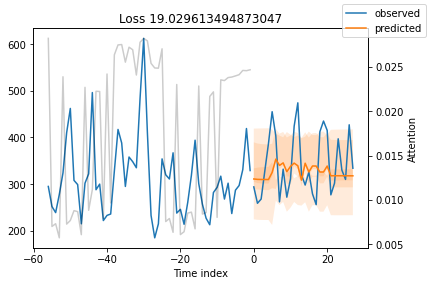

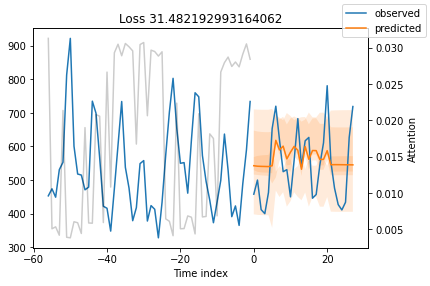

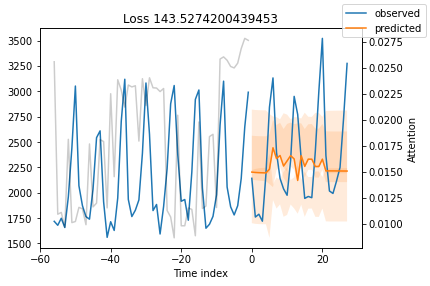

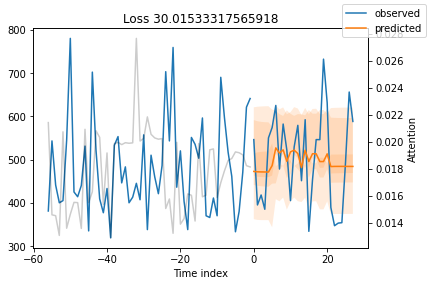

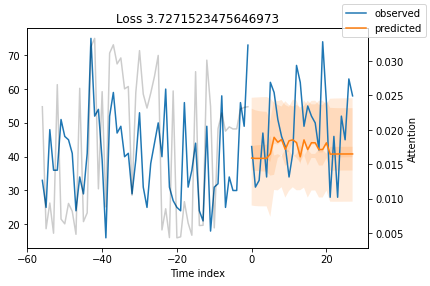

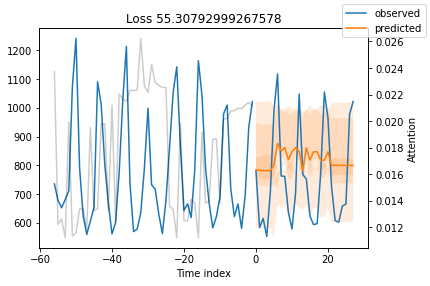

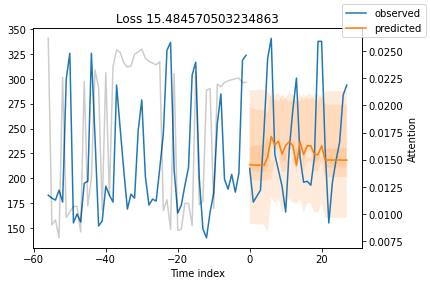

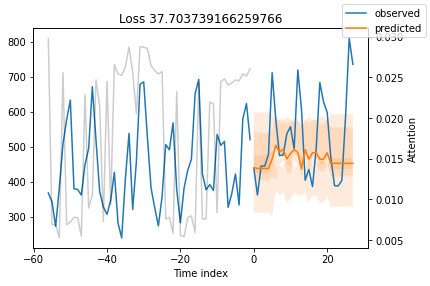

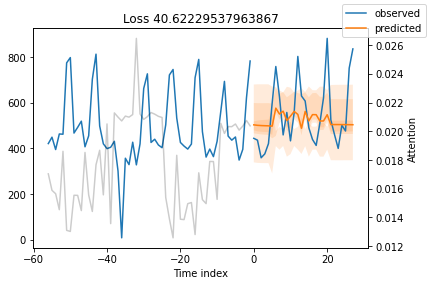

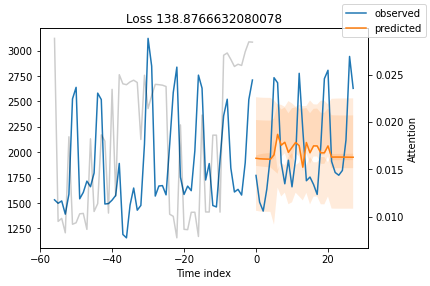

In [33]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

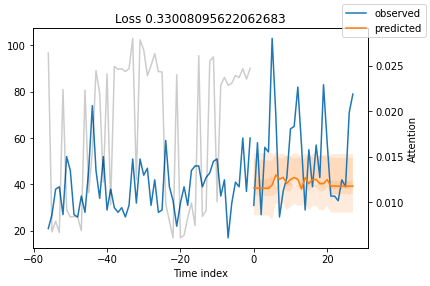

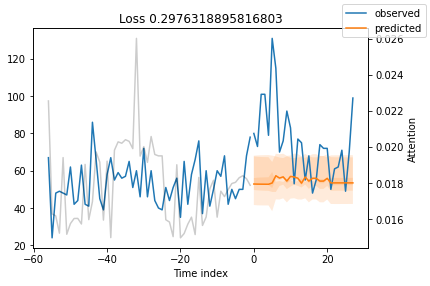

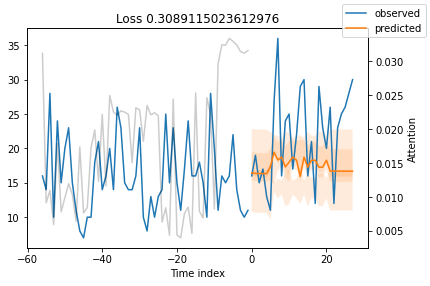

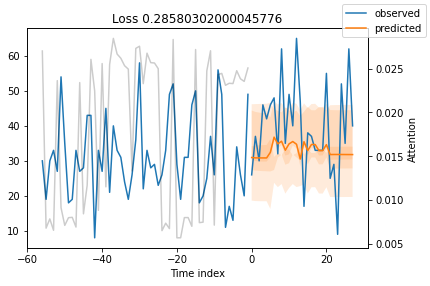

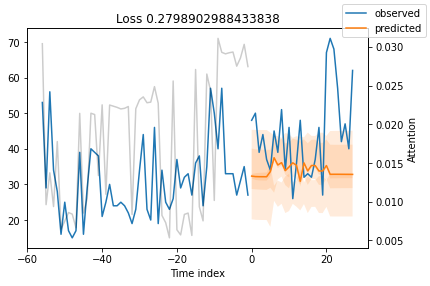

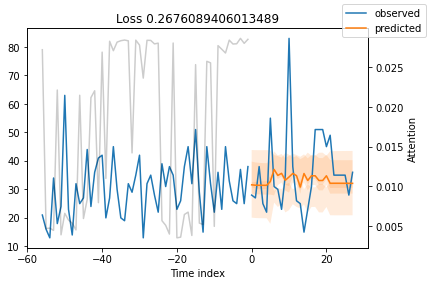

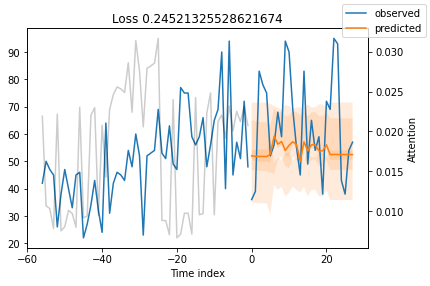

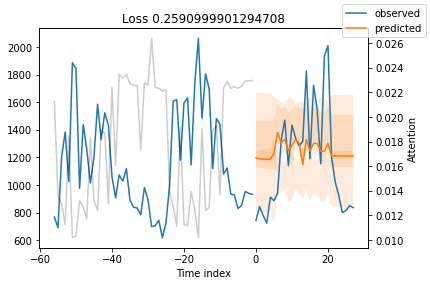

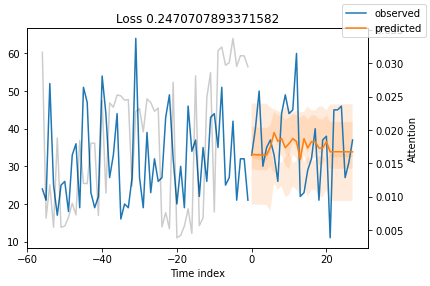

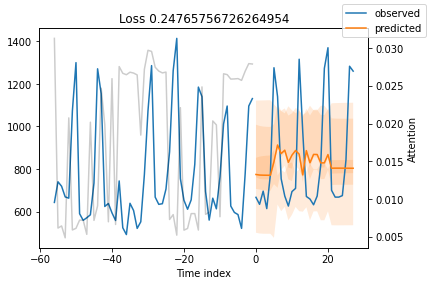

In [34]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

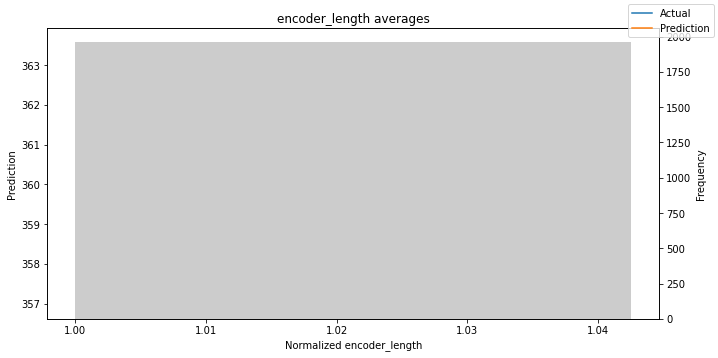

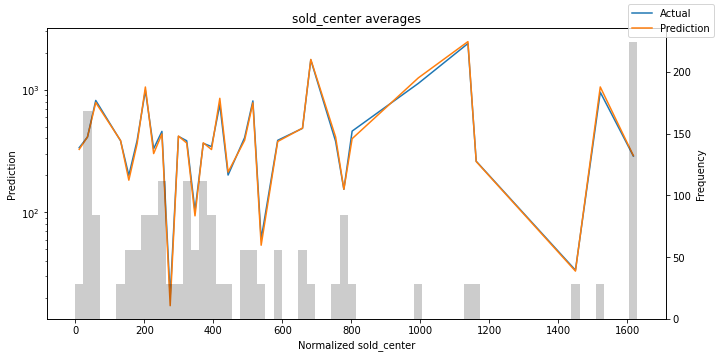

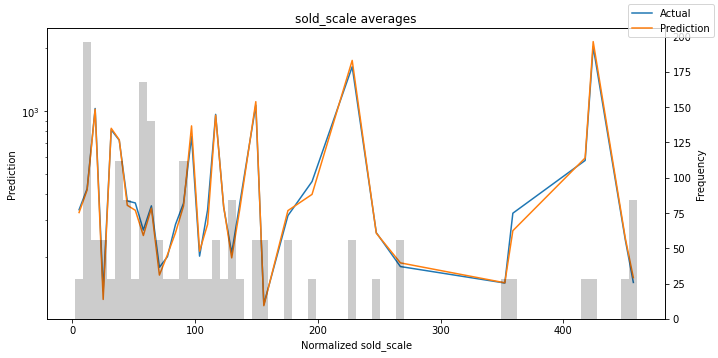

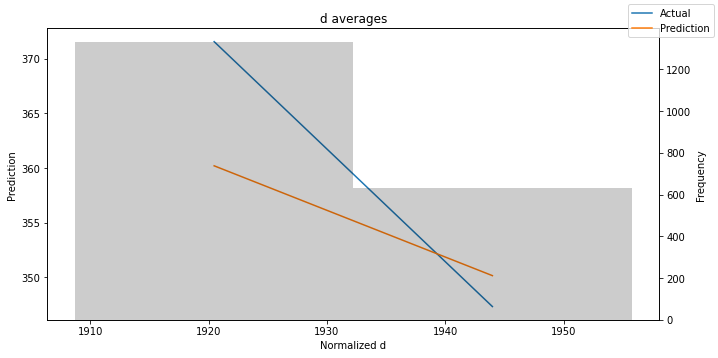

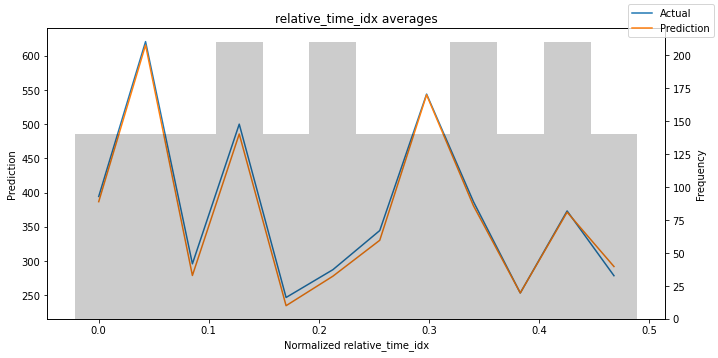

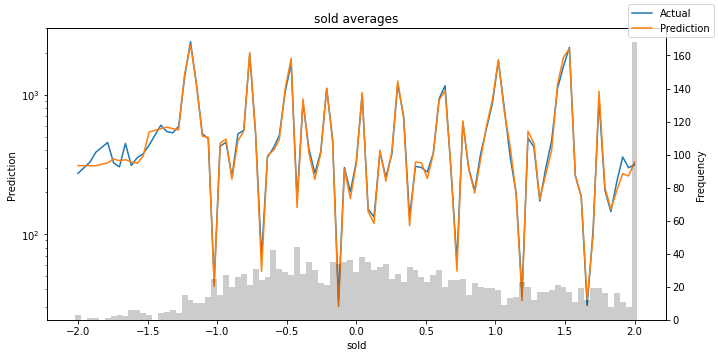

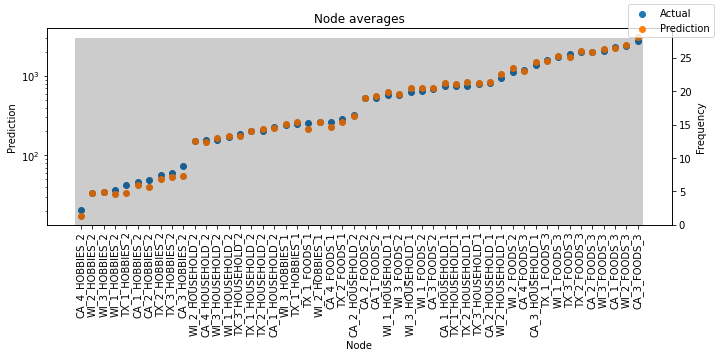

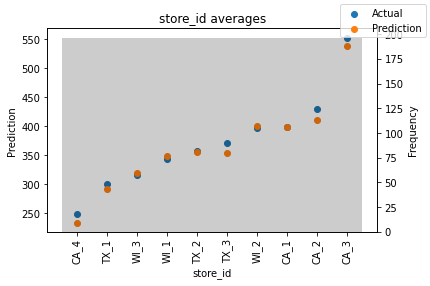

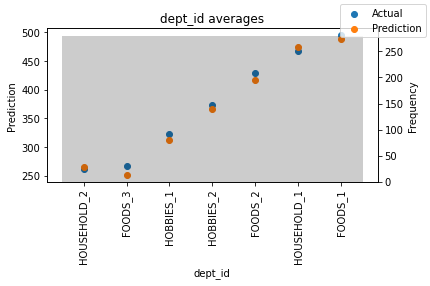

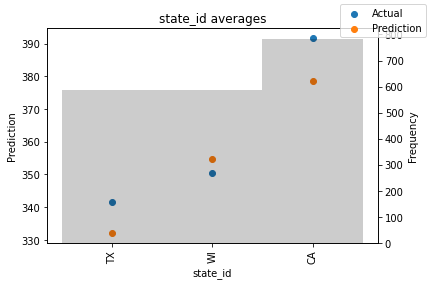

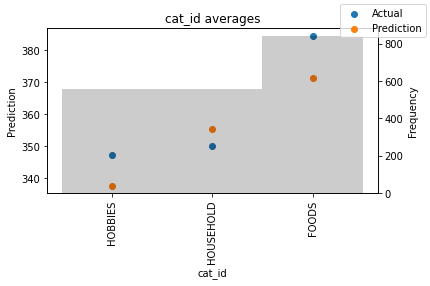

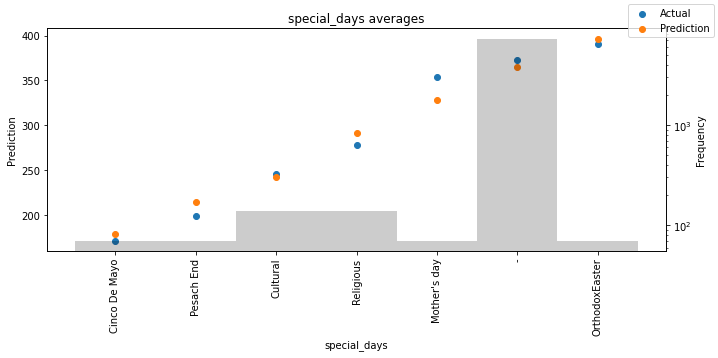

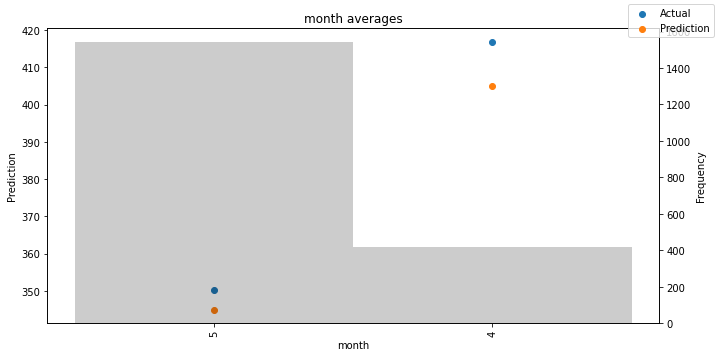

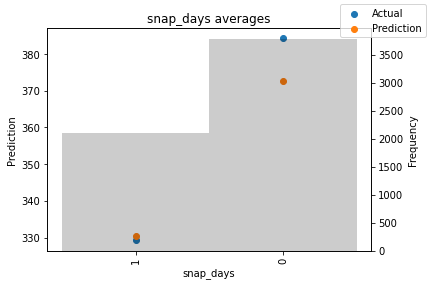

In [35]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x288 with 1 Axes>,
 'encoder_variables': <Figure size 504x252 with 1 Axes>,
 'decoder_variables': <Figure size 504x234 with 1 Axes>}

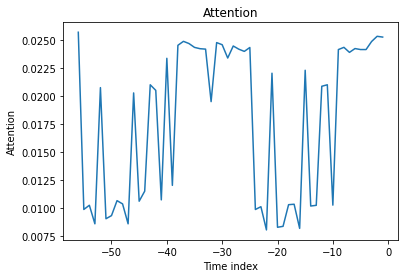

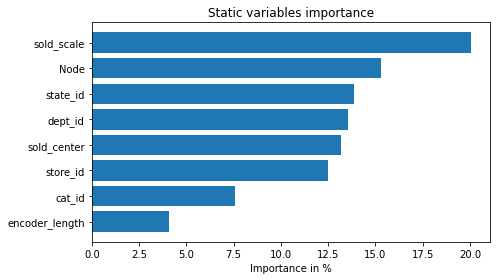

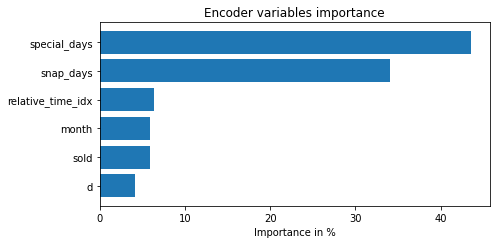

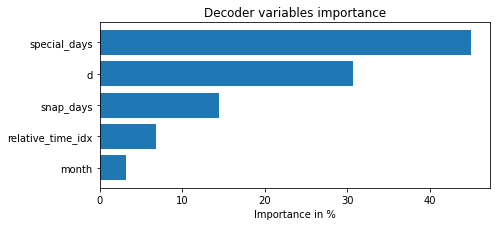

In [36]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)